
## Plate Recognition in Images using Unet as Neural Network model

In [46]:
# IMPORTS
# usefulls urls:
# dataset and dataloader of pytorch: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# neural network of pytorch: https://pytorch.org/docs/stable/nn.html
# the dataset we use (all credits to them): 
# DataBase "A Robust and Efficient Approach to License Plate Detection." IEEE Trans Image Process (2017):1102-1114.
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision import transforms as T
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss
import cv2

In [2]:
import os
os.environ["HIP_VISIBLE_DEVICES"] = "1" # Keep this line for good measure, it might help with some internal ROCm ops.

import torch

print(f"HIP_VISIBLE_DEVICES (from os.environ): {os.environ.get('HIP_VISIBLE_DEVICES')}")
print(torch.cuda.is_available())
print(torch.cuda.device_count())

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

    # THIS IS THE CRUCIAL CHANGE: Explicitly select device 1
    my_device = torch.device("cuda:0")
    print(f"\nUsing explicit device: {my_device}")

else:
    my_device = torch.device("cpu")
    print("\nCUDA/ROCm not available, falling back to CPU.")

HIP_VISIBLE_DEVICES (from os.environ): 1
True
1
Device 0: AMD Radeon RX 7800 XT

Using explicit device: cuda:0


In [3]:
# choose the devise, it will use the gpu if is available
# my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(my_device)
print(torch.cuda.get_device_name(0))

cuda:0
AMD Radeon RX 7800 XT


In [7]:
# mount the drive files
# this only works if you have a graphic card NVIDIA
# drive.mount('/content/drive')

In [4]:
# FILE PATHS
# you should copy and past the file direction of the dataset you use

# specific path of the folder that contain the train data
# PATH_DATA = 'C:/Users/pc/Desktop/ai/unet_patent_detector/dataset/images'
# # specific path of the folder that contain the train masks
# PATH_MASK = 'C:/Users/pc/Desktop/ai/unet_patent_detector/dataset/masks'

PATH_DATA = 'dataset/images'
PATH_MASK = 'dataset/masks'


In [5]:
# DATASET

# custom class of dataset, this will load all the files of the data_path and mask_path
class Plates_Dataset(Dataset):

  def __init__(self,data_path,mask_path,transform_data,transform_mask):
    self.data_path = data_path
    self.mask_path = mask_path
    self.transform_data = transform_data
    self.transform_mask = transform_mask

    self.images = sorted(os.listdir(self.data_path))
    self.masks = sorted(os.listdir(self.mask_path))

  def __len__(self):
    return len(self.masks)

  def __getitem__(self, idx):
    img_path = os.path.join(self.data_path, self.images[idx])
    image = Image.open(img_path)
    mask_path = os.path.join(self.mask_path, self.masks[idx])
    mask = Image.open(mask_path)
    if self.transform_data is not None:
      image = self.transform_data(image)
    if self.transform_mask is not None:
      mask = self.transform_mask(mask)
    mask = (torch.sum(mask,dim=0)/3).unsqueeze(0)
    # the image is returned in 3 channels (rgb) and the mask in 1 channels (scale of grays) because is only 2 classes 
    return image, mask

In [6]:
# transforms
# the image and the mask will use the same tranform, you can change this if you need

# transform =  T.Compose([T.Resize([224, 224]),T.ToTensor()])
transform =  T.Compose([T.Resize([320, 320]),T.ToTensor()])

In [7]:
# call of the dataset class
 
full_dataset = Plates_Dataset(PATH_DATA,PATH_MASK,transform,transform)

In [8]:
# CONSTANTS

# the number of images
DATASET_SIZE = len(full_dataset)
# size for the batches
BATCH_SIZE = 32
# the size of the train that we will use for training, the rest of the train dataset will be use for monitoring
TRAIN_SIZE = int(0.80*DATASET_SIZE)
# the size of the test files
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE
# the size of the validation o monitoring files
VALID_SIZE = int(0.1*TRAIN_SIZE)

In [9]:
# split the complete train_dataset in two tensors:
# one t_dataset only for train
# the second test_dataset for testing

# split full_dateset train as t_dataset and test_dataset
t_dataset, test_dataset = random_split(full_dataset, [TRAIN_SIZE, TEST_SIZE])
# t_dataset split it self as train and validation
train_dataset, valid_dataset = random_split(t_dataset, [TRAIN_SIZE-VALID_SIZE, VALID_SIZE])

In [10]:
print('Length of train dataset: ',len(train_dataset))
print('Length of validation dataset: ',len(valid_dataset))
print('Length of test dataset: ',len(test_dataset))
print('Total of files in the dataset: ',len(full_dataset))

Length of train dataset:  2863
Length of validation dataset:  318
Length of test dataset:  796
Total of files in the dataset:  3977


In [11]:
# DATALOADER

# Preparing your data for training with DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validate_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# PLOT THE BATCH

# this function plot the images and their masks
def plot_batch(batch_size,imgs,masks):
  plt.figure(figsize=(20,10))
  for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    img = imgs[i,...].permute(1,2,0).numpy()
    mask = masks[i, ...].permute(1,2,0).numpy()
    plt.imshow(img)
    plt.imshow(mask, cmap='gray',alpha=0.75)

    plt.axis('Off')
  plt.tight_layout()
  plt.show()

torch.Size([32, 3, 320, 320]) torch.Size([32, 1, 320, 320])


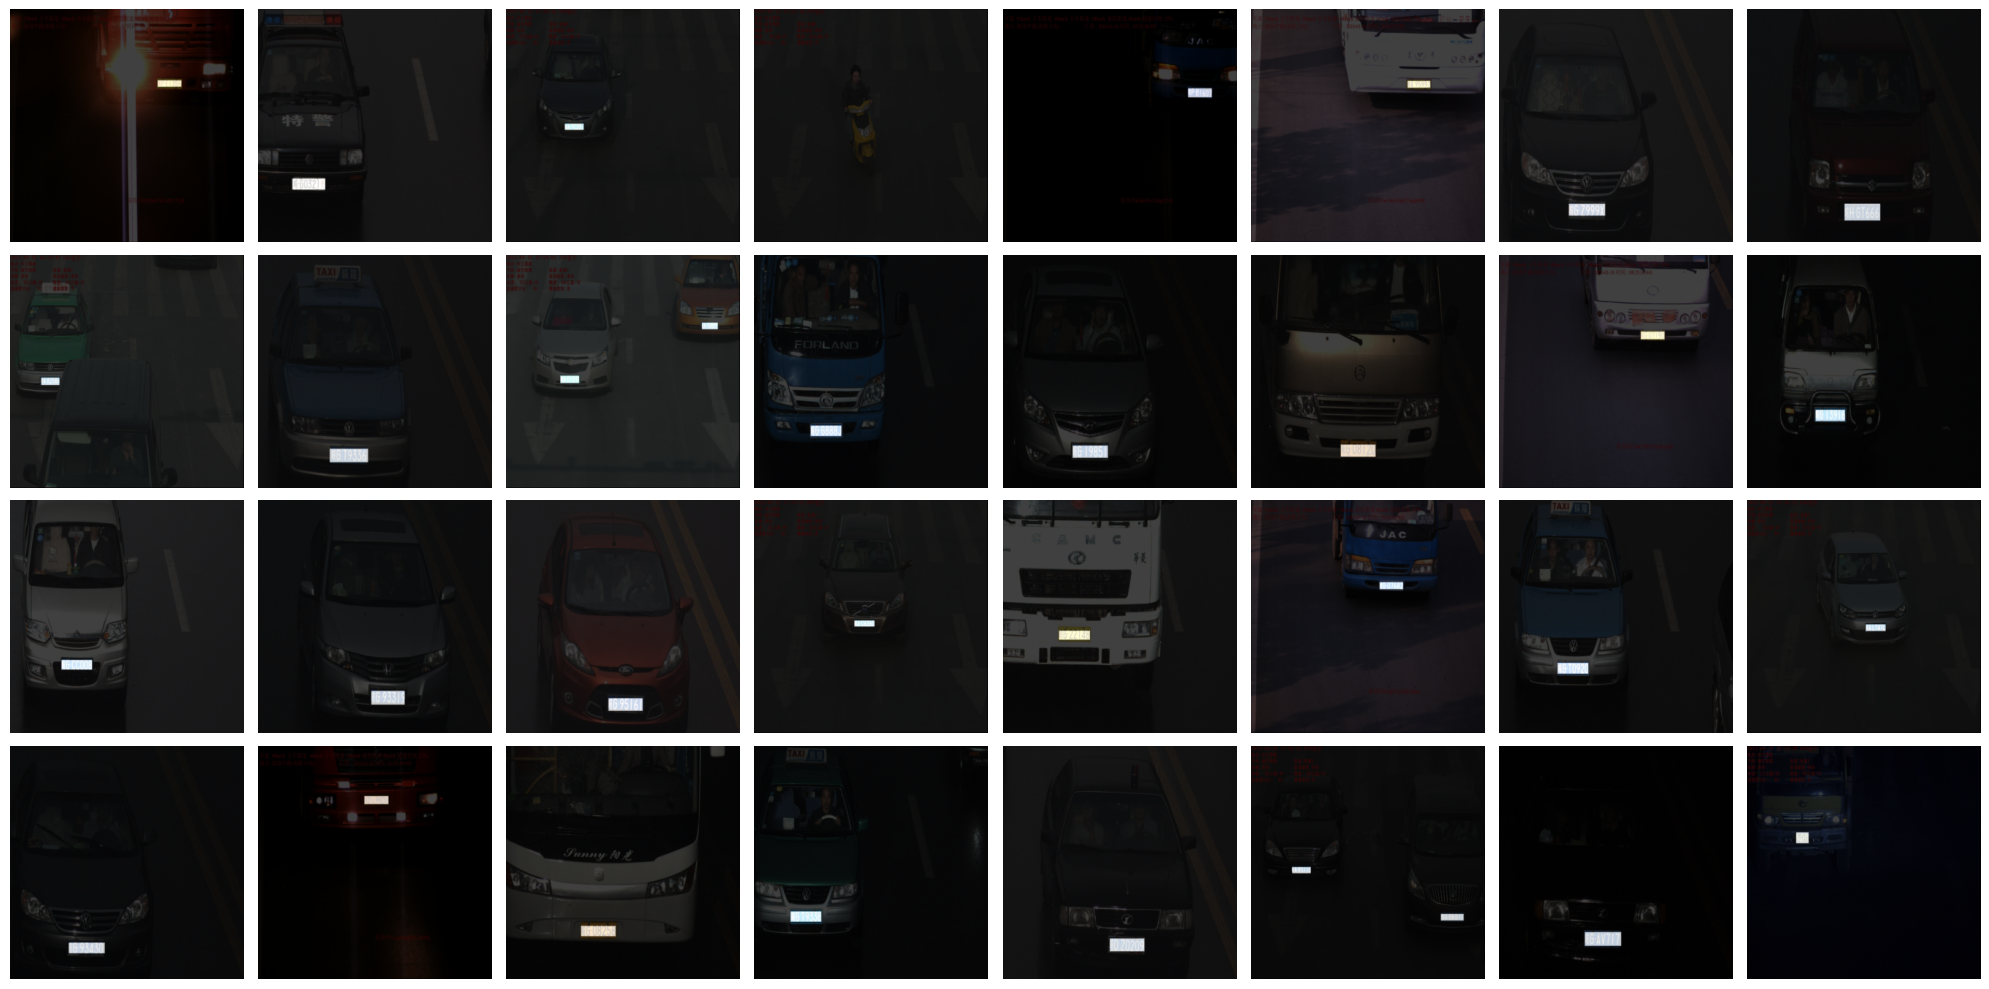

In [13]:
# plot some examples

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)
plot_batch(BATCH_SIZE,imgs, masks)

In [14]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [15]:
class Double_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),

                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

In [16]:
class Down_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

In [17]:
class Up_Conv(nn.Module):
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

In [18]:
# the class of the UNET implementation
class UNET(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels)
        self.down_conv1 = Down_Conv(channels, 2*channels) 
        self.down_conv2 = Down_Conv(2*channels, 4*channels) 
        self.down_conv3 = Down_Conv(4*channels, 8*channels) 

        self.middle_conv = Down_Conv(8*channels, 16*channels) 

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.sigmoid(self.last_conv(u4))

In [19]:
# this function calculate the dice and iou metrics for the validation data
def metrics(model, data):
  intersection = 0;  denom = 0;  union = 0;  loss_acum = 0
  model.to(device=my_device)
  with torch.no_grad():  # Turn off gradients computation
    for x,y in data:
      x = x.to(device=my_device, dtype=torch.float32)             # send the data to the gpu
      # y = y.to(device=my_device, dtype=torch.long).squeeze(1)
      y = y.to(device=my_device, dtype=torch.float32).squeeze(1)

      y_pred = model(x).squeeze(1)
      # optimizer.zero_grad()                                         
      loss = F.binary_cross_entropy(y_pred, y).to(device=my_device)
      loss_acum+= loss.item()

      #dice coefficient
      intersection += (y_pred*y).sum()
      denom += (y_pred + y).sum()
      #intersection over union
      union += (y_pred + y - y_pred*y).sum()
    dice = 2*intersection/(denom + 1e-8)
    iou = (intersection)/(union + 1e-5)                       # not divide by zero

  return dice, iou, loss_acum

In [20]:
# # TRAIN
def train(model, train_data, validate_data, optimizer, epochs = 100, step_store = 10, pacient = 10, tol_error = 1e-2):
  acum_v = []
  model = model.to(device=my_device)
  iou_v = []
  dice_v = []
  model.train()                                                     # calculate the gradients
  for epoch in range(epochs):
    acum = 0
    pacient_step = 0
    for batch, (x,y) in enumerate(train_data, start=1):             # loop for every batch
      x = x.to(device=my_device, dtype=torch.float32)               # send the data to the gpu
      y = y.to(device=my_device, dtype=torch.float32)
      y_pred = model(x)
      optimizer.zero_grad()                                         # clean the optimizers cache
      loss = F.binary_cross_entropy(y_pred, y).to(device=my_device) # loss function
      acum+=loss.item()
      loss.backward()                                               # Backward pass
      optimizer.step()                                              # update the nn
      # in every step calculated the metrics, if the model is not learning more than tol_error, the trainning will break
      if batch%step_store == 0:
        dice,iou,loss = metrics(model,validate_data)
        iou_v.append(iou)
        dice_v.append(dice)
        print(f' dice: {dice}, iou: {iou}')
        if loss < tol_error:                                   # breaking the trainning by tolerance error
          if pacient_step < pacient:
            pacient_step+=1
          else:
            break
    print('epoch ',epoch,' acumulated: ',acum)
    acum_v.append(acum)
  plt.plot(acum_v)
  plt.show()
        
  return iou_v,dice_v

In [21]:
# define the model and optimizer
model = UNET(channels_in=3, channels=32, num_classes=1)

In [22]:
# define the number of epochs
epochs = 20
# define the optimizer
optimizer_unet = torch.optim.SGD(model.parameters(),lr=1e-2, momentum=0.95)

 dice: 0.014411546289920807, iou: 0.007258073892444372
 dice: 0.027245888486504555, iou: 0.013811091892421246
 dice: 0.040477652102708817, iou: 0.020656896755099297
 dice: 0.07758621126413345, iou: 0.04035874456167221
 dice: 0.11839127540588379, iou: 0.06292025744915009
 dice: 0.15358789265155792, iou: 0.08318180590867996
 dice: 0.18308070302009583, iou: 0.10076434165239334
 dice: 0.21261516213417053, iou: 0.11895321309566498
 dice: 0.24839717149734497, iou: 0.14181137084960938
epoch  0  acumulated:  7.000414278358221
 dice: 0.29474198818206787, iou: 0.17284303903579712
 dice: 0.35498079657554626, iou: 0.21579128503799438
 dice: 0.4540514349937439, iou: 0.293704092502594
 dice: 0.5364827513694763, iou: 0.3665708601474762
 dice: 0.6057776212692261, iou: 0.4344913959503174
 dice: 0.6432157754898071, iou: 0.47407373785972595
 dice: 0.6659717559814453, iou: 0.4992187023162842
 dice: 0.6832922697067261, iou: 0.5189399719238281
 dice: 0.698605477809906, iou: 0.536812961101532
epoch  1  acumu

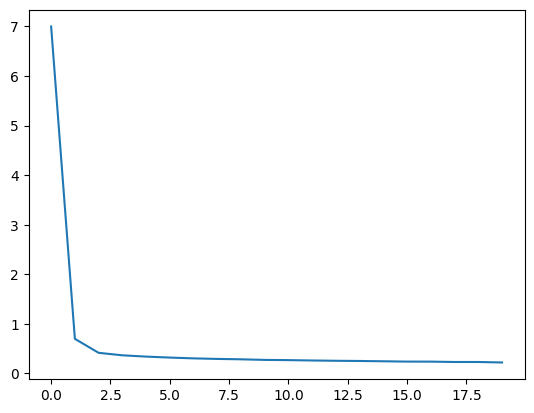

In [24]:
# training the model
iou_v,dice_v = train(model, train_loader, validate_loader, optimizer_unet, epochs, step_store=10, pacient=15, tol_error=1e-2)

In [25]:
torch.save(model, 'model8c_5e_ce.pt')
torch.save(model.state_dict(), 'model16c_50e_bcelog_state_dict.pt')

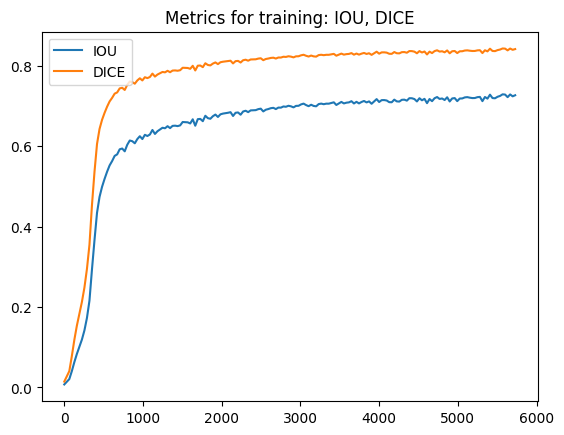

In [26]:
# some plot of the metrics
x = BATCH_SIZE*np.arange(0,len(iou_v))
plt.plot(x,torch.Tensor(iou_v),label='IOU')
plt.plot(x,torch.Tensor(dice_v),label='DICE')
plt.xlabel('')
plt.ylabel('')
plt.title('Metrics for training: IOU, DICE')
plt.legend(loc="upper left")
plt.show()

In [27]:
# TEST
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 320, 320])


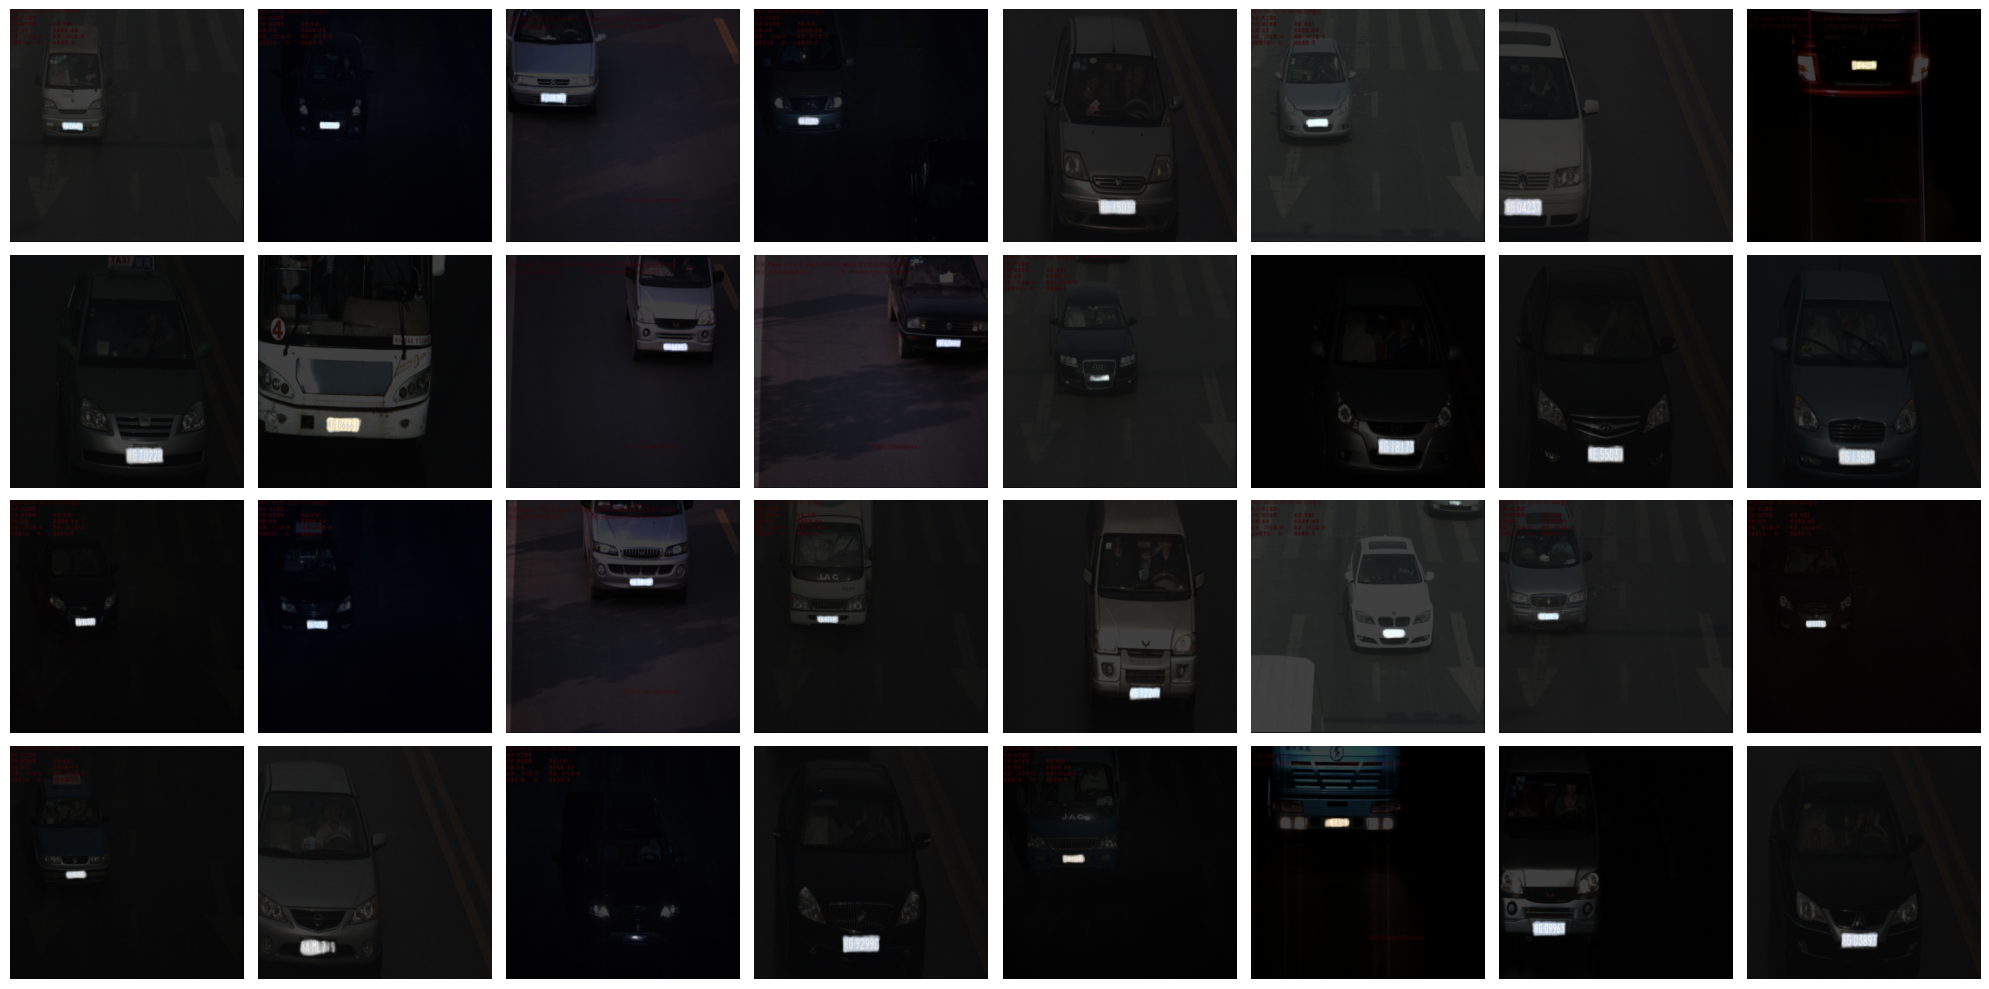

In [28]:
# plot of some predicts

imgs_test,masks_test = next(iter(test_loader))
model = model.to(device=my_device)
imgs_test = imgs_test.cuda('cuda:0')
with torch.no_grad():
  scores = model(imgs_test)
  preds = scores[:,0]

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_batch(BATCH_SIZE,imgs_test, preds.unsqueeze(1))

In [38]:
# def test(model,data):
#   dice, iou, loss = metrics(model, data)
#   print(f"size of the data: {len(data)}")
#   return iou,dice

In [39]:
def test(model, data):  
    iou_v = []; dice_v = []
    model = model.to(device=my_device)
    for batch, (x,y) in enumerate(data, start=1):             # loop for every batch
        dice,iou,loss = metrics(model,data)
        iou_v.append(iou)
        dice_v.append(dice)
        print(f' dice: {dice}, iou: {iou}')   
    return iou_v,dice_v

In [40]:
iou_v_test,dice_v_test = test(model, test_loader)

 dice: 0.847825825214386, iou: 0.735848605632782
 dice: 0.8482314348220825, iou: 0.7364598512649536
 dice: 0.8463627099990845, iou: 0.7336471676826477
 dice: 0.8474060893058777, iou: 0.7352166175842285
 dice: 0.8469652533531189, iou: 0.7345531582832336
 dice: 0.8478497862815857, iou: 0.7358847260475159
 dice: 0.8479242920875549, iou: 0.735997200012207
 dice: 0.8478106260299683, iou: 0.7358256578445435
 dice: 0.848644495010376, iou: 0.7370828986167908
 dice: 0.8473026752471924, iou: 0.7350607514381409
 dice: 0.8476707935333252, iou: 0.7356152534484863
 dice: 0.8485355973243713, iou: 0.736918568611145
 dice: 0.8482022285461426, iou: 0.7364158630371094
 dice: 0.8473942279815674, iou: 0.7351986765861511
 dice: 0.8477832078933716, iou: 0.7357845902442932
 dice: 0.848177433013916, iou: 0.7363786697387695
 dice: 0.8473220467567444, iou: 0.7350900769233704
 dice: 0.8471994400024414, iou: 0.734905481338501
 dice: 0.8464622497558594, iou: 0.7337967753410339
 dice: 0.848143458366394, iou: 0.73632

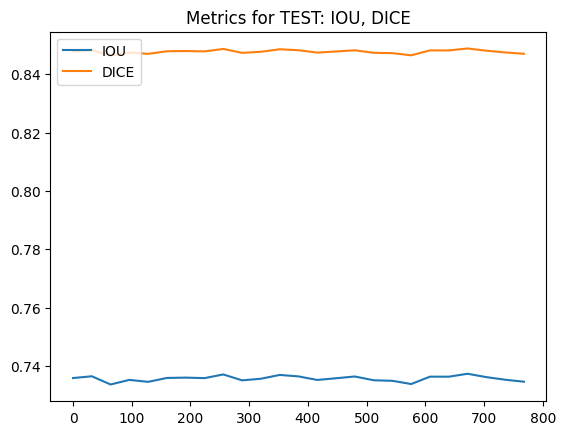

In [41]:
# plot of the test metrics
x = BATCH_SIZE*np.arange(0,len(iou_v_test))
plt.plot(x,torch.Tensor(iou_v_test),label='IOU')
plt.plot(x,torch.Tensor(dice_v_test),label='DICE')
plt.xlabel('')
plt.ylabel('')
plt.title('Metrics for TEST: IOU, DICE')
plt.legend(loc="upper left")
plt.show()

In [104]:

model.load_state_dict(torch.load('model16c_50e_bcelog_state_dict.pt', weights_only=True,map_location='cuda:0'))



<All keys matched successfully>

In [42]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
imgs_test,masks_test = next(iter(test_loader))

In [43]:
def predict(model, test_images):
    print(f"length of test_images: {len(test_images)}")
    # imgs_test, masks_test = next(iter(test_loader))
    model = model.to(device=my_device)
    imgs_test = test_images.cuda('cuda:0')
    with torch.no_grad():
        scores = model(imgs_test)
        preds = scores[:,0]

        imgs_test = imgs_test.cpu()
        preds = preds.cpu()
    return imgs_test, preds.unsqueeze(1)

In [44]:
predict_img, preds = predict(model, test_images=imgs_test)
print(predict_img.shape, preds.shape)

length of test_images: 32
torch.Size([32, 3, 320, 320]) torch.Size([32, 1, 320, 320])


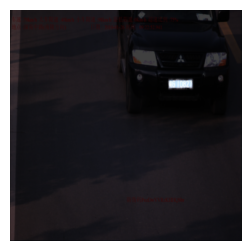

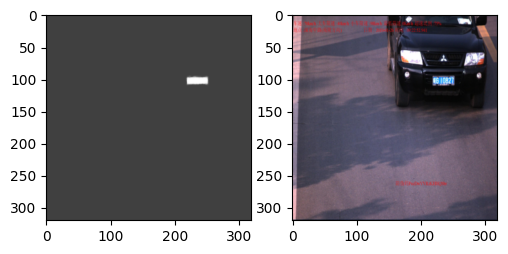

In [45]:
plot_batch(1, predict_img, preds)

plt.figure(figsize=(9, 3))
plt.subplot(131)
mask = preds[0, ...].permute(1,2,0).numpy()
plt.imshow(mask, cmap='gray',alpha=0.75)
plt.subplot(132)
img = predict_img[0,...].permute(1,2,0).numpy()
plt.imshow(img)
plt.show()

In [55]:
def get_plate(image_path, model, threshold_min=0.5, threshold_max=0.9):
    """
    Extract license plate region from an image using the trained UNET model.
    
    Args:
        image_path (str): Path to the input image
        model: Trained UNET model
        threshold_min (float): Minimum threshold for mask binarization
        threshold_max (float): Maximum threshold for mask binarization
    
    Returns:
        tuple: (plate_tensor, original_image, mask) - extracted plate as tensor, original image, and mask
    """
    # Load and transform the image
    image_load = Image.open(image_path)
    transform = T.Compose([T.Resize([512, 512]), T.ToTensor()])  # Using same size as training
    
    image_tensor = transform(image_load)
    image_batch = image_tensor.unsqueeze(0)  # Add batch dimension
    
    # Predict the mask using the model
    model = model.to(device=my_device)
    image_batch = image_batch.to(device=my_device)
    
    with torch.no_grad():
        scores = model(image_batch)
        preds = scores[:, 0]
        
        # Move back to CPU for processing
        image_batch = image_batch.cpu()
        preds = preds.cpu()
    
    # Convert to numpy for image processing
    original_img = image_batch[0].permute(1, 2, 0).numpy()
    mask = preds[0].numpy()
    
    print(f"Mask shape: {mask.shape}")
    print(f"Mask min/max values: {mask.min():.3f}/{mask.max():.3f}")
    
    # Create binary mask
    binary_mask = cv2.inRange(mask, threshold_min, threshold_max)
    
    # Find bounding box coordinates
    y_indices, x_indices = np.nonzero(binary_mask)
    
    if len(y_indices) == 0 or len(x_indices) == 0:
        print("No license plate detected in the image")
        return None, original_img, mask
    
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    
    print(f'Bounding box - xmin: {x_min}, xmax: {x_max}, ymin: {y_min}, ymax: {y_max}')
    
    # Extract the plate region
    plate_region = original_img[y_min:y_max, x_min:x_max, :]
    
    # Convert back to tensor format
    plate_tensor = torch.from_numpy(plate_region).permute(2, 0, 1).unsqueeze(0)
    
    return plate_tensor, original_img, mask

In [56]:

# Usage example:
plate, original, mask = get_plate('dataset/images/G1 (15).jpg', model)


Mask shape: (512, 512)
Mask min/max values: 0.000/1.000
Bounding box - xmin: 131, xmax: 211, ymin: 374, ymax: 404


Extracted plate shape: torch.Size([1, 3, 30, 80])


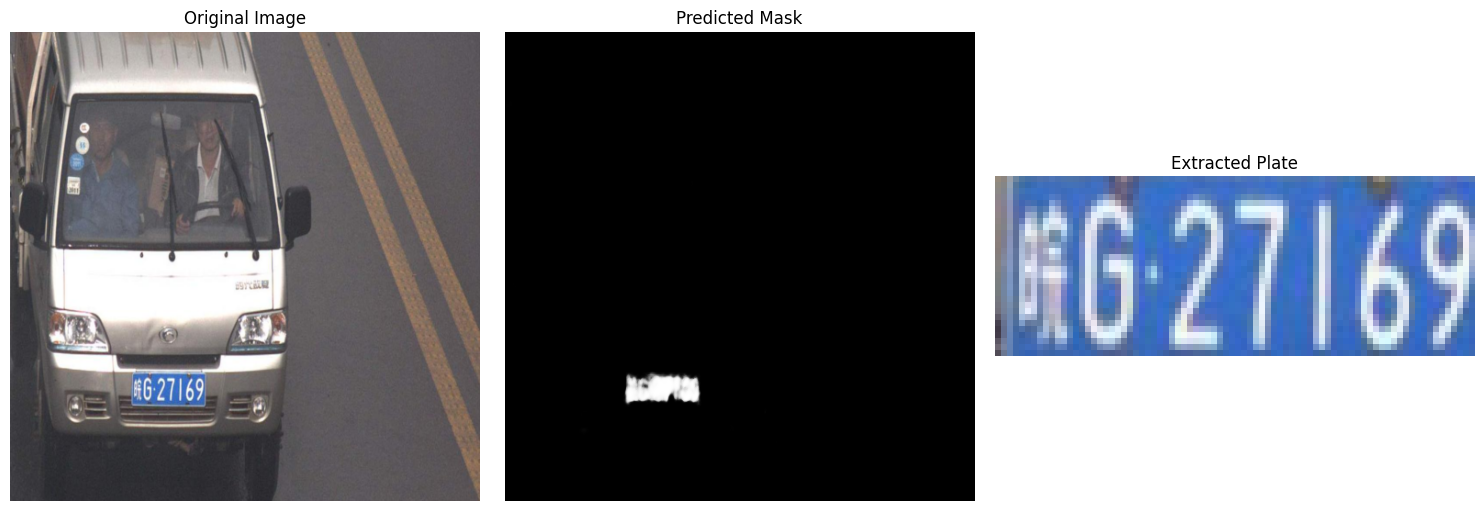

In [57]:

if plate is not None:
    print(f"Extracted plate shape: {plate.shape}")
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(plate[0].permute(1, 2, 0).numpy())
    plt.title('Extracted Plate')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not extract license plate from the image")